<a href="https://colab.research.google.com/github/aimanismail21/Project-Treehouse/blob/master/A2_Aiman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
pip install fastai

In [121]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

Load dataset

In [122]:
import fastai
from fastai.torch_core import tensor
from fastai.vision.all import *
import numpy as np
from matplotlib import pyplot as plt

In [123]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#4) [Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/models'),Path('/root/.fastai/data/camvid_tiny/codes.txt')]

The images folder contains the images, and the corresponding segmentation masks of labels are in the labels folder. The codes file contains the corresponding integer to class (the masks have an int value for each pixel).

In [124]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [125]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/root/.fastai/data/camvid_tiny/images/0001TP_008400.png')

In [126]:
(path/"labels").ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08370_P.png')

In [127]:
def label_func(fn): 
  return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [128]:
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [129]:
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=8,
    fnames=fnames,
    label_func=label_func,
    codes=codes,
    valid_pct=0.2
    # batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)]
)

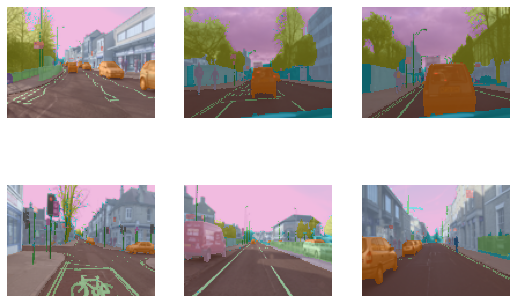

In [130]:
dls.show_batch(max_n=6)

A traditional CNN won't work for segmentation, we have to use a special kind of model called a UNet, so we use unet_learner to define our Learner:

In [149]:
learn = unet_learner(dls,
                     resnet34,
                     pretrained=True,
                     metrics=[IoU]
                    #  metrics=[foreground_acc, Dice, DiceMulti, JaccardCoeff]
                     )

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.00019054606673307717)

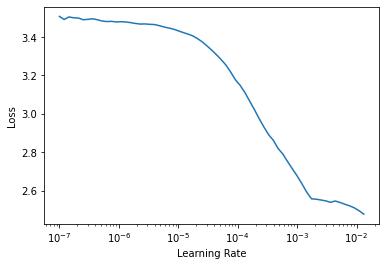

In [150]:
learn.lr_find()

We will use the fine_tune method to specialize our base model for the specific task of segmentation for the masks we've provided.

This is a form of transfer learning since we're using a base model UNet that uses the Resnet34 model as its backbone. In other words, these models have been trained up to recognize a variety of things so we don't have to start from the beginning.

In [153]:
learn.fine_tune(epochs=6, base_lr=0.00132, pct_start=0.9)

epoch,train_loss,valid_loss,Dice,time
0,1.958162,1.915123,None,00:01


TypeError: ignored

The tuning parameters suggest a training epoch length of 5


In [ ]:
m = learn.model
m

In [143]:
counter=0
for param in m[0].parameters():
  counter+=1;
print(f"There are {counter} parameters")

There are 108 parameters


And as before, we can get some idea of the predicted results with show_results

In [ ]:
learn.show_results(max_n=4, figsize=(6,6), shuffle=True)
learn.show_results(max_n=4, figsize=(6,6), shuffle=True)

Another thing that is useful is an interpretation object, it can show us where the model made the worse predictions: